In [65]:
import pandas as pd
import geopandas as gpd
import geodatasets
import h3pandas
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import tskit
import tszip
import sys
sys.path.append("/Users/jameskitchens/Documents/GitHub/terracotta")
import terracotta as tct
import importlib
importlib.reload(tct)
import time

In [66]:
# Prepare data
gdf = gpd.read_file(geodatasets.get_url("naturalearth land"))
gdf = gdf.loc[112:112]

gdf.explore()

In [67]:
resolution = 2
gdf_h3 = gdf.h3.polyfill_resample(resolution)
gdf_h3 = gdf_h3.reset_index()
gdf_h3["deme"] = gdf_h3.index

In [68]:
gdf_h3.explore()

325, 347, 704 - antimeridian
575, 683 - Kamchatka
539 - Korea
537, 692 - Thailand pennisula

In [69]:
gdf_h3 = gdf_h3.drop([518, 527, 755, 622, 641, 25, 680, 57]) #drop these because of antimeridian
gdf_h3.explore()

In [70]:
sample_locs = pd.read_csv("sample_locations.csv")
sample_locs = gpd.GeoDataFrame(sample_locs, geometry=gpd.GeoSeries.from_xy(sample_locs["lon"], sample_locs["lat"]), crs=4326)
sample_locs.explore()

In [71]:
sample_locs_with_region = gpd.sjoin(sample_locs, gdf_h3, how="inner", predicate="within").loc[:, ["id", "deme"]]
sample_locs_with_region = sample_locs_with_region.drop_duplicates("deme")
regions_with_samples = sample_locs_with_region["deme"].unique()

color = []
for i,deme in gdf_h3.iterrows():
    if deme["deme"] in regions_with_samples:
        color.append("orange")
    else:
        color.append("blue")
gdf_h3["color"] = color

In [75]:
gdf_h3.explore(color=gdf_h3["color"])

In [76]:
gdf_h3["geometry"] = gdf_h3.buffer(0.1)
with open("demes.tsv", "w") as outfile:
    outfile.write("id\txcoord\tycoord\ttype\tneighbours\n")
    for i, row in gdf_h3.iterrows():
        neighbors = np.array(gdf_h3[gdf_h3.geometry.touches(row['geometry'])].deme)
        #overlapping neighbors use if discrepances found with touches
        overlap = np.array(gdf_h3[gdf_h3.geometry.overlaps(row['geometry'])].deme)
        neighbors = [str(d) for d in np.sort(np.union1d(neighbors, overlap))]
        center = row["geometry"].centroid
        outfile.write(f"{row["deme"]}\t{center.x}\t{center.y}\t0\t{",".join(neighbors)}\n")

/var/folders/q8/b10jdgls4xvcv3wz767kf6f80000gn/T/ipykernel_40992/188448912.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_h3["geometry"] = gdf_h3.buffer(0.1)


In [45]:
import tszip
import sys
sys.path.append("/Users/jameskitchens/Documents/GitHub/terracotta")
import terracotta as tct
import importlib
importlib.reload(tct)

<module 'terracotta' from '/Users/jameskitchens/Documents/GitHub/terracotta/terracotta/__init__.py'>

In [77]:
ts = tszip.load("hgdp_tgp_sgdp_high_cov_ancients_chr17_p.dated.trees.tsz")
print(ts)
ts, map_nodes = ts.simplify(samples=sample_locs_with_region["id"], map_nodes=True)

╔═════════════════════════╗
║TreeSequence             ║
╠═══════════════╤═════════╣
║Trees          │    52974║
╟───────────────┼─────────╢
║Sequence Length│ 25050000║
╟───────────────┼─────────╢
║Time Units     │  unknown║
╟───────────────┼─────────╢
║Sample Nodes   │     7524║
╟───────────────┼─────────╢
║Total Size     │242.4 MiB║
╚═══════════════╧═════════╝
╔═══════════╤═════════╤════════╤════════════╗
║Table      │Rows     │Size    │Has Metadata║
╠═══════════╪═════════╪════════╪════════════╣
║Edges      │2,551,601│77.9 MiB│          No║
╟───────────┼─────────┼────────┼────────────╢
║Individuals│    3,762│ 1.1 MiB│         Yes║
╟───────────┼─────────┼────────┼────────────╢
║Migrations │        0│ 8 Bytes│          No║
╟───────────┼─────────┼────────┼────────────╢
║Mutations  │2,151,003│75.9 MiB│          No║
╟───────────┼─────────┼────────┼────────────╢
║Nodes      │  253,440│12.6 MiB│         Yes║
╟───────────┼─────────┼────────┼────────────╢
║Populations│      215│11.9 KiB│      

In [78]:
sample_locs_with_region["orig_id"] = sample_locs_with_region["id"]
sample_locs_with_region["id"] = map_nodes[sample_locs_with_region["id"]]
print(len(sample_locs_with_region))
sample_locs_with_region.to_csv("samples.tsv", sep="\t", index=False)

78


In [63]:
demes = pd.read_csv("demes.tsv", sep="\t")
samples = pd.read_csv("samples.tsv", sep="\t")

world_map = tct.WorldMap(demes, samples)

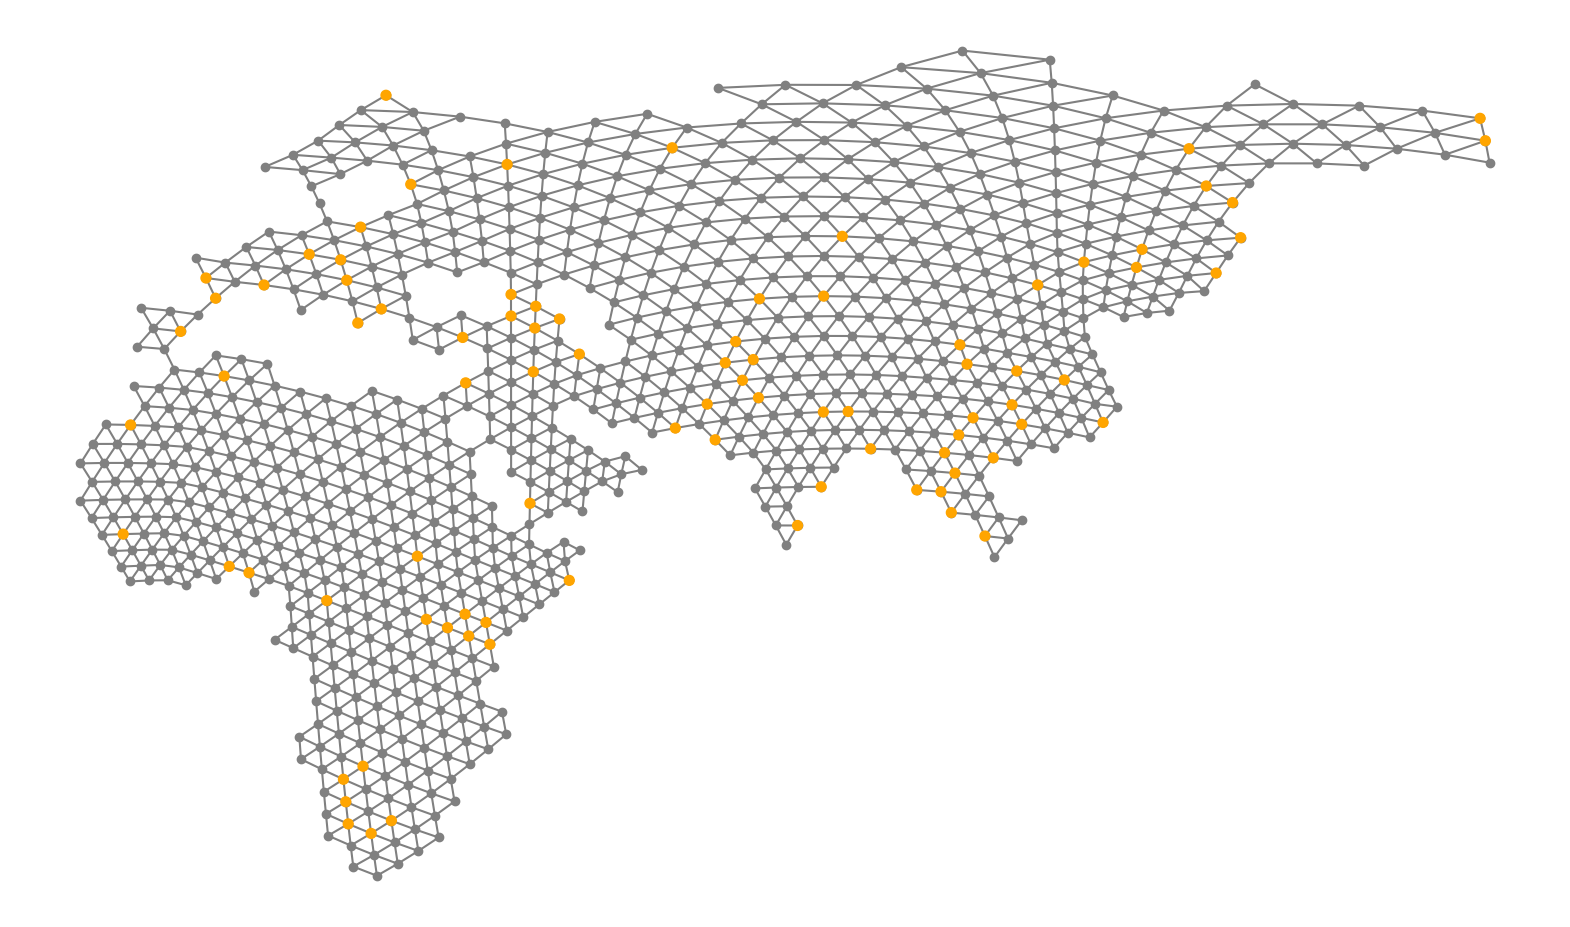

In [64]:
world_map.draw(figsize=(20,20), show_samples=True)

In [80]:
from os import mkdir

def create_trees_folder_from_ts(ts, output_path=".", gap_between_trees=1):
    mkdir(f"{output_path}/trees")
    for i in range(0, ts.num_trees, gap_between_trees):
        tree = ts.at_index(i)
        interval = tree.interval
        single_tree_ts = ts.keep_intervals([interval], simplify=True).trim()
        single_tree_ts.dump(f"{output_path}/trees/{i}.trees")

In [82]:
create_trees_folder_from_ts(
    ts=ts,
    gap_between_trees=1000
)

In [55]:
from glob import glob
import tskit

trees = [tskit.load(ts).first() for ts in glob(f"trees/*")]

nwalkers = 10
niter = 1000
initial_mr = np.array([0.1 for connection_type in world_map.connections.type.unique()])
ndim = len(initial_mr)
p0 = [np.array(initial_mr) + 1e-2 * np.random.randn(ndim) for i in range(nwalkers)]
sampler, pos, prob, state = tct.mcmc.run(p0, nwalkers, niter, world_map, trees)

samples = sampler.flatchain
theta_max  = samples[np.argmax(sampler.flatlnprobability)]
print(theta_max)

Running burn-in...
Precalculating transitions...
0
98
172
239
296
352
398
455
500
547
579
618
652
688
714
739
766
Calculating loglikelihoods per tree...
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
Precalculating transitions...
0
98
172
239
296
352
398
455
500
547
579
618
652
688
714
739
766
Calculating loglikelihoods per tree...
0
1
2
3
4
5
6
7
8
emcee: Exception while calling your likelihood function:
  params: [0.09020763]
  args: [<terracotta.main.WorldMap object at 0x15f5b64b0>, [<tskit.trees.Tree object at 0x15f3bfd40>, <tskit.trees.Tree object at 0x160088b00>, <tskit.trees.Tree object at 0x16008ad80>, <tskit.trees.Tree object at 0x1600888f0>, <tskit.trees.Tree object at 0x16008a720>, <tskit.trees.Tree object at 0x160089460>, <tskit.trees.Tree object at 0x1600888c0>, <tskit.trees.Tree object at 0x160089f70>, <tskit.trees.Tree object at 0x15fd79b20>, <tskit.trees.Tree object at 0x15ea88e60>, <tskit.trees.Tree object at 0x160073560>, <tskit.trees.Tree object at 0x1600726f0>, <tskit.tre

Traceback (most recent call last):
  File "/opt/anaconda3/envs/terracotta/lib/python3.12/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jameskitchens/Documents/GitHub/terracotta/terracotta/mcmc.py", line 16, in lnprob
    return lp + calc_migration_rate_log_likelihood(
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jameskitchens/Documents/GitHub/terracotta/terracotta/main.py", line 319, in calc_migration_rate_log_likelihood
    log_likelihoods.append(_calc_tree_log_likelihood(tree, world_map.sample_location_vectors, precomputed_transitions=precomputed_transitions)[0])
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jameskitchens/Documents/GitHub/terracotta/terracotta/main.py", line 268, in _calc_tree_log_likelihood
    outgoing_log_message 

KeyboardInterrupt: 

In [1]:
import pandas as pd
import geopandas as gpd
import geodatasets
import h3pandas
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import tskit
import tszip
import sys
sys.path.append("/Users/jameskitchens/Documents/GitHub/terracotta")
import terracotta as tct
import importlib
importlib.reload(tct)
import time

In [53]:
demes = pd.read_csv("demes.tsv", sep="\t")
samples = pd.read_csv("samples.tsv", sep="\t")

world_map = tct.WorldMap(demes, samples)

trees = [tskit.load(ts).first() for ts in glob(f"trees/*")]

start = time.time()
tct.calc_migration_rate_log_likelihood(
    world_map=world_map,
    trees=trees,
    migration_rates={0:0.01}
)[0]
print(time.time() - start)

Precalculating transitions...
0
98
172
239
296
352
398
455
500
547
579
618
652
688
714
739
766
Calculating loglikelihoods per tree...
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
130.33200907707214


In [54]:
bls = []
trees = [tskit.load(ts).first() for ts in glob(f"trees/*")]
for tree in trees:
    for node in tree.nodes(order="timeasc"):
        bls.append(tree.branch_length(node))

print(len(bls), len(set(bls)))

2246 792


In [18]:
from scipy import linalg
transition_matrix = world_map.build_transition_matrix(migration_rates={0:0.01})
where_next = linalg.expm(transition_matrix*1)
if np.any(where_next <= 0):
    where_next[where_next <= 0] = 1e-99

In [11]:
import itertools
import operator

ts = tszip.load("hgdp_tgp_sgdp_high_cov_ancients_chr17_p.dated.trees.tsz")

branch_lengths = []
for parent, edges in itertools.groupby(ts.edges(), operator.attrgetter("parent")):
    bls = {}
    for edge in edges:
        if edge.child not in branch_lengths:
            bls[edge.child] = ts.node(parent).time - ts.node(edge.child).time
    unique_bls = set(bls.values())
    branch_lengths.extend(unique_bls)
print(len(branch_lengths))
print(len(set(branch_lengths)))

KeyboardInterrupt: 